In [1]:
%load_ext autoreload
%autoreload 2

In [37]:
from rdkit import Chem
from pathlib import Path
import torch 
from collections import namedtuple
from copy import deepcopy
import os
import numpy as np
import pandas as pd
import prolif as plf
import MDAnalysis as mda
from torch_scatter import scatter_mean

from e3mol.experiments.sampling.interaction_recovery import compute_prolif_interaction
from e3mol.experiments.data.datainfo import load_dataset_info
from e3mol.experiments.data.dataset import LigandPocketDataModule as DataModule
from e3mol.experiments.data.fragmentation import FragmentTransform
from e3mol.experiments.sampling.evaluate_pose import wrap_vina, wrap_posebusters_sdf, wrap_posebusters_mols

In [3]:
from rdkit.Chem.Draw import IPythonConsole
import py3Dmol

IPythonConsole.molSize = (400, 400)   # Change image size
IPythonConsole.ipython_useSVG = True  # Change output to SVG
IPythonConsole.ipython_maxProperties = 0

def show_atom_number(mol, label):
    mol = deepcopy(mol)
    for atom in mol.GetAtoms():
        atom.SetProp(label, str(atom.GetIdx()))
    return mol
    
def view_3d(mol):
    view = py3Dmol.view(
    data=Chem.MolToMolBlock(mol),  # Convert the RDKit molecule for py3Dmol
    style={"stick": {}, "sphere": {"scale": 0.1}}
    )
    return view.zoomTo()


def check_for_disconnected_components(rdmol):
    mol_frags = Chem.rdmolops.GetMolFrags(
                        rdmol, asMols=True, sanitizeFrags=False
                    )
    return len(mol_frags) < 2


## Download

Please download model weights from the kinodata3d model here: https://figshare.com/articles/dataset/Checkpoints_to_lightning_model/30739268?file=59948612

The paths will decompress into 
```
ckpts/
└── kinodata3d/
    ├── diffusion/
    ├── flow/
    │   ├── recap/
    │   ├── brics/
    │   └── cutable/
    │       └── best_valid.ckpt
```

-----

Dataset for loading statistics can be downloaded here: https://figshare.com/articles/dataset/Datasets_including_CrossDocked2020_and_KinoData-3D/30739232?file=59947856

Choose the kinodata3d folder as `datapath`

In [ ]:
bp = Path("./ckpt/kinodata3d/flow/cutable/")
datapath = Path("./data/kinodata3d/")
path = bp / "best_valid.ckpt"

In [5]:
ckpt = torch.load(path, map_location="cpu")
hparams = torch.load(path, map_location="cpu")["hyper_parameters"]
hparams = namedtuple("hparams", hparams.keys())(*hparams.values())
hparams = hparams._replace(batch_size=1)
hparams = hparams._replace(dataset_root=str(datapath))

In [6]:
transform = FragmentTransform(minFragmentSize=6, method="briccs-recap")
datamodule = DataModule(hparams, transform=transform)
datamodule.setup()
statistics_dict_path = hparams.dataset_root + "/processed/all_stats_dict_noh.pickle"
dataset_info = load_dataset_info(
    name=hparams.dataset,
    statistics_dict_path=statistics_dict_path,
    ligand_pocket_histogram_path=None,
)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [8]:
from e3mol.experiments.trainer import TrainerFlow as Trainer
from e3mol.experiments.sampling.inpaint_ligands_multi import create_batch_from_pl_files

model = Trainer.load_from_checkpoint(path,
                                     dataset_info=dataset_info,
                                     pocket_noise_std=hparams.pocket_noise_std,
                                     smiles=datamodule.train_dataset.smiles,
                                    ).to(device)
model.smiles_train = datamodule.train_dataset.smiles

Using Protein-Ligand Flow Model


In [9]:
sdf_file = Path("data/ligand.sdf")
protein_file = Path("data/protein.pdb")
fixed_sdf_file = Path("data/fixed_context.sdf")

In [10]:
# Wrap the posebusters SDF file with the reference PDB and the first PDB file
reference_pb_df = wrap_posebusters_sdf(sdf_file, sdf_file, protein_file)

In [11]:
reference_pb_df

,,,mol_pred_loaded,mol_cond_loaded,sanitization,inchi_convertible,all_atoms_connected,no_radicals,bond_lengths,bond_angles,internal_steric_clash,aromatic_ring_flatness,...,internal_energy,protein-ligand_maximum_distance,minimum_distance_to_protein,minimum_distance_to_organic_cofactors,minimum_distance_to_inorganic_cofactors,minimum_distance_to_waters,volume_overlap_with_protein,volume_overlap_with_organic_cofactors,volume_overlap_with_inorganic_cofactors,volume_overlap_with_waters
file,molecule,position,,,,,,,,,,,,,,,,,,,,,
data/ligand.sdf,PF-07976265,0,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


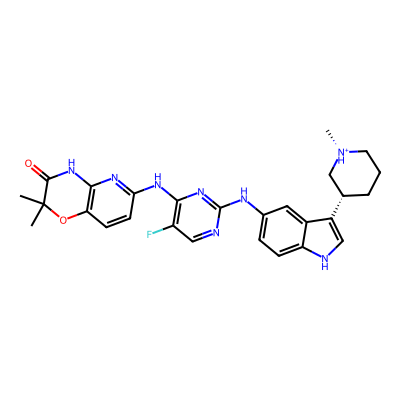

In [12]:
mol = Chem.SDMolSupplier(str(sdf_file))[0]
mol2d = deepcopy(mol)
mol2d.RemoveAllConformers()
mol2d

In [13]:
reference_pb_df.values.mean(1).mean(0)

1.0

The reference ligand `PF-07976265` is posebusters valid 

Let us compute the vina pose score. Make sure to pass the path to the binary vina executable

In [ ]:
qvina2_path = "/qvina2.1"

In [15]:
vina_scores = wrap_vina(sdf_file, protein_file, qvina2_path=qvina2_path) 
vina_scores

,mols,score,nHeavyAtoms
0,<rdkit.Chem.rdchem.Mol object at 0x1553eded28f0>,-13.29281,38


#### Visualize interactions

In [16]:
res, fp = compute_prolif_interaction(
    ligands=sdf_file,
    protein=protein_file,
    return_fp=True,
)

In [17]:
lig = plf.molecule.Molecule.from_rdkit(Chem.AddHs(mol, addCoords=True))
prot = plf.Molecule.from_mda(mda.Universe(str(protein_file)))

In [18]:
view_3d_prolif = fp.plot_3d(lig, prot, frame=0, display_all=False)
view_3d_prolif

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

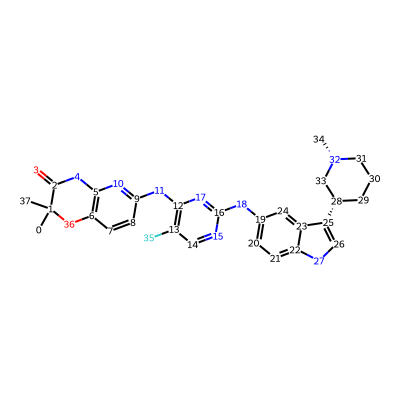

In [19]:
show_atom_number(mol2d, "atomLabel")

In [20]:
remove_ids = [19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
anchor_ids = [18]
keep_ids = [i for i in range(mol.GetNumAtoms()) if i not in remove_ids]

In [21]:
print("Reference molecule has {} atoms.".format(mol.GetNumAtoms()))
print(len(remove_ids), "atoms are removed from the reference molecule.")

Reference molecule has 38 atoms.
16 atoms are removed from the reference molecule.


### We perform substructure fragment replacement and change the hightlighted atoms

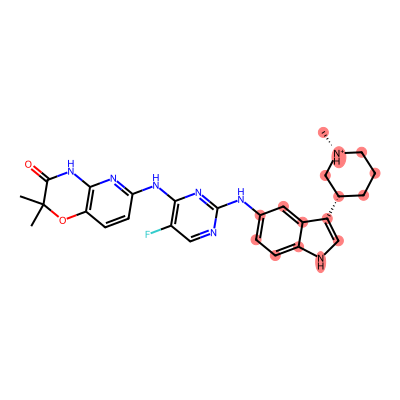

In [22]:
Chem.Draw.MolToImage(mol2d, highlightAtoms=remove_ids, size=(400, 400))

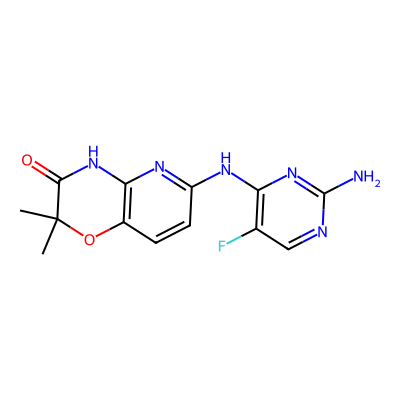

In [23]:
fixed_ligand = Chem.SDMolSupplier(fixed_sdf_file)[0]
fixed_ligand_2d = deepcopy(fixed_ligand)
fixed_ligand_2d.RemoveAllConformers()
fixed_ligand_2d

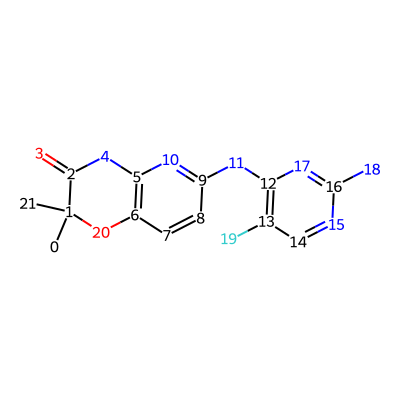

In [24]:
show_atom_number(fixed_ligand_2d, label="atomLabel")

The model generates in the 0-CoM of the pocket. Let us compute the localized mean of the fragment that we want to replace

In [25]:
data = create_batch_from_pl_files(
                    pdb_file=protein_file,
                    sdf_file=sdf_file,
                    batch_size=1,
                    pocket_cutoff=5.0,
                    removeHs_ligand_post=True,
                    removeHs_pocket_post=True,
                    inpainting=False,
                ).to(device)

In [26]:
pocket_com = scatter_mean(data.pos_pocket, index=data.pos_pocket_batch, dim=0)
lig_pos = data.pos - pocket_com[data.batch]

In [27]:
pos_prior = lig_pos[remove_ids].mean(0)
print(pos_prior)

tensor([-1.9810,  0.0315,  5.2143], device='cuda:0')


In [28]:
pos_prior = torch.tensor([-1.9810,  0.0315,  5.2143], device=device, dtype=torch.float32).unsqueeze(0)
pos_prior

tensor([[-1.9810,  0.0315,  5.2143]], device='cuda:0')

In [29]:
gen_mols = []
iterations = 2
batch_size = 32
min_nodes_bias = 8
max_nodes_bias = 20
num_integration_steps = 100

for iteration in range(iterations):
    data = create_batch_from_pl_files(
                    pdb_file=protein_file,
                    sdf_file=sdf_file,
                    inpaint_file=fixed_sdf_file,
                    batch_size=batch_size,
                    pocket_cutoff=5.0,
                    removeHs_ligand_post=True,
                    removeHs_pocket_post=True,
                    inpainting=True,
                    keep_ids=np.arange(fixed_ligand_2d.GetNumAtoms()).tolist(),
                    anchor_idx=[18],
                    min_nodes_bias=min_nodes_bias,
                    max_nodes_bias=max_nodes_bias,
                ).to(device)

    num_graphs = len(data.batch.bincount())
    with torch.no_grad():
        molecules, traj, cl_loss = model.model.reverse_sampling_node_level_t(
            N=num_integration_steps,
            device=model.device,
            pocket_data=data,
            verbose=True,
            save_traj=False,
            cat_noise=True,
            pos_noise=False,
            clash_guidance=False,
            clash_guidance_scale=0.05,
            score_dynamics=True,
            score_scale=0.5,
            dt_pow=0.5,
            pos_prior=pos_prior.repeat_interleave(batch_size, dim=0),
        )
    rdmols = [m.rdkit_mol for m in molecules]
    is_valid = []
    for i, mol in enumerate(rdmols):
        try:
            Chem.SanitizeMol(mol)
            if check_for_disconnected_components(mol):
                is_valid.append(i)
        except: 
            pass
    rdmols_valid = [rdmols[i] for i in is_valid]
    gen_mols.extend(rdmols_valid)

100%|██████████| 100/100 [00:16<00:00,  6.15it/s]
[15:57:31] Explicit valence for atom # 28 O, 2, is greater than permitted
[15:57:31] Explicit valence for atom # 27 F, 2, is greater than permitted
100%|██████████| 100/100 [00:16<00:00,  5.97it/s]


In [30]:
view_3d(rdmols_valid[0])

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
mols2d = [deepcopy(mol) for mol in gen_mols]
for m in mols2d: m.RemoveAllConformers()
Chem.Draw.MolsToGridImage(mols2d, molsPerRow=8 ,subImgSize=(200, 200), legends=[str(i) for i in range(len(mols2d))])

In [32]:
gen_mols[:16]

#### Check PoseBusters validity and Vina Pose Score of 16 first generated molecules

In [33]:
pb_res = wrap_posebusters_mols(mols=gen_mols[:16],
                               ref_file=str(sdf_file),
                               pdb_file=str(protein_file),
                               return_input_mols=False
                               )

In [34]:
pb_res.values.mean(-1).mean(0)

1.0

In [35]:
vina_scores_gen = wrap_vina(gen_mols[:16], protein_file, qvina2_path=qvina2_path) 

In [36]:
vina_scores_gen

,mols,score,nHeavyAtoms
0,<rdkit.Chem.rdchem.Mol object at 0x1553ec66da10>,-11.99570,31
1,<rdkit.Chem.rdchem.Mol object at 0x1553ec66dbd0>,-12.60306,38
2,<rdkit.Chem.rdchem.Mol object at 0x1553ec66dcb0>,-12.77592,41
3,<rdkit.Chem.rdchem.Mol object at 0x1553ec66ee30>,-13.06659,35
4,<rdkit.Chem.rdchem.Mol object at 0x1553ec66ec70>,-11.83136,41
5,<rdkit.Chem.rdchem.Mol object at 0x1553ec66ef10>,-12.49796,34
6,<rdkit.Chem.rdchem.Mol object at 0x1553ec66eea0>,-11.95645,35
7,<rdkit.Chem.rdchem.Mol object at 0x1553ec66ed50>,-13.38863,39
8,<rdkit.Chem.rdchem.Mol object at 0x1553ec66f060>,-12.45542,33
9,<rdkit.Chem.rdchem.Mol object at 0x1553ec66ef80>,-13.46057,38
